In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import xgboost as xgb

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import optuna
import os
from scipy import stats

from tensorflow import keras
from tensorflow.keras import layers

import joblib

In [16]:
train = pd.read_csv("../data/train.csv")
predict = pd.read_csv("../data/test.csv")

# データの前処理

In [17]:
def create_features(df):
    # カーブと報告事故件数
    df['curavture_accidents'] = df['curvature'] * df['num_reported_accidents']
    #df['time_school_accidents'] = df['time_of_day'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['weather_accidents'] = df['weather'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['speed_accidents'] = df['speed_limit'] * df['num_reported_accidents']
    #df['cuavature_speed'] = df['curvature'] * df['speed_limit']

    #df['cuvature_weather'] = df['curvature'] * df['weather'].map(mapping)

    return df

train = create_features(train)
predict = create_features(predict)

In [18]:
# One-Hot Encoding
def one_hot_encode(df, columns):
    df = pd.get_dummies(df, columns=columns, drop_first=False)
    return df

encode_columns = ['road_type', 'lighting', 'weather', 'time_of_day']

# trainとpredictで同じダミー列に揃えるための処理
train = one_hot_encode(train, encode_columns)
predict = one_hot_encode(predict, encode_columns)

# 列がずれないように、trainにあってpredictにない列を補う
missing_cols = set(train.columns) - set(predict.columns)
for col in missing_cols:
    predict[col] = 0

# 列の順番をtrainと合わせる
predict = predict[train.columns]
predict = predict.drop(columns=['accident_risk'])

In [19]:
# bool型の変換

def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df

train = bool_to_int(train)
predict = bool_to_int(predict)

# スケーリング

In [20]:
# 残留誤差が大きいため，異常値に強いRobustScalerを使用
def robust_scale(df):
    scaler = RobustScaler()

    numeric_columns = ['curvature','curavture_accidents']

    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

train = robust_scale(train)
predict = robust_scale(predict)

# データ分割

In [21]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(columns=['id','accident_risk'])
    y = df['accident_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)

predict_X = predict.copy()
predict_X = predict_X.drop(columns=['id'])

# モデルの読み込み

In [22]:
def load_model(path):
    loaded_model = keras.models.load_model(path)
    return loaded_model

In [23]:
# ファイルパスの定義
file_path_xgboost = "model/xgboost_model/xgboost_model_2.json"
file_path_lgb = "model/lgb_model/lgb_model_3.pkl"
file_path_deep = "model/deep_model/dl_accident_risk_model_4.h5"

# xgboostの読み込み
xgb_model = xgb.Booster()
xgb_model.load_model(file_path_xgboost)

lgb_model = joblib.load(file_path_lgb)

# deep learning modelの読み込み
deep_model = keras.models.load_model(file_path_deep)

In [24]:
dtest = xgb.DMatrix(X_test)
xgb_pred = xgb_model.predict(dtest)

lgb_pred = lgb_model.predict(X_test)

deep_pred = deep_model.predict(X_test).reshape(-1)

3236/3236 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [25]:

print(f"xgb_pred shape: {xgb_pred.shape}")
print(f"deep_pred shape: {deep_pred.shape}")


xgb_pred shape: (103551,)
deep_pred shape: (103551,)


In [26]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error

# --- モデル予測 ---
#dtest = xgb.DMatrix(X_test)
#xgb_pred = xgb_model.predict(dtest)          # XGBoost予測
#deep_pred = deep_model.predict(X_test).reshape(-1)  # Deep Learning予測（形を統一）

# --- 最適化関数の定義 ---
def optimize_weight(trial):
    # w_xgb: XGBoostの重み, w_dl: Deep Learningの重み
    w_xgb = trial.suggest_float('xgb_weight', 0.0, 1.0)
    w_lgb = trial.suggest_float('lgb_weight', 0.0, 1.0)
    w_dl = trial.suggest_float('dl_weight', 0.0, 1.0)

    # 重みの正規化
    total_weight = w_xgb + w_lgb + w_dl
    w_xgb /= total_weight
    w_lgb /= total_weight
    w_dl /= total_weight

    final_pred = w_xgb * xgb_pred + w_lgb * lgb_pred + w_dl * deep_pred
    
    mse = mean_squared_error(y_test, final_pred)
    return mse

# --- Optunaで探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(optimize_weight, n_trials=400, show_progress_bar=True)

# --- 最適重みの取得 ---
best_params = study.best_params
best_w_xgb = study.best_params['xgb_weight']
best_w_lgb = study.best_params['lgb_weight']
best_w_dl = study.best_params['dl_weight']

# 重みの正規化
total_weight = best_w_xgb + best_w_lgb + best_w_dl
best_w_xgb /= total_weight
best_w_lgb /= total_weight
best_w_dl /= total_weight

print(f"Best weights -> XGBoost: {best_w_xgb:.4f}, LightGBM: {best_w_lgb:.4f}, Deep Learning: {best_w_dl:.4f}")

# --- 最適重みで最終予測 ---
final_pred = best_w_xgb * xgb_pred + best_w_lgb * lgb_pred + best_w_dl * deep_pred

# --- 評価 ---
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
print(f"Final RMSE: {rmse:.4f}")


[I 2025-10-18 19:19:14,369] A new study created in memory with name: no-name-eb75d0a9-7315-48d9-b167-f317a606d1db


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2025-10-18 19:19:14,436] Trial 0 finished with value: 0.0031636110987864887 and parameters: {'xgb_weight': 0.9806605980246, 'lgb_weight': 0.7220573057321217, 'dl_weight': 0.7957828209264578}. Best is trial 0 with value: 0.0031636110987864887.
[I 2025-10-18 19:19:14,439] Trial 1 finished with value: 0.0031618605113310234 and parameters: {'xgb_weight': 0.8458576734935515, 'lgb_weight': 0.25786791540018095, 'dl_weight': 0.42465276763448745}. Best is trial 1 with value: 0.0031618605113310234.
[I 2025-10-18 19:19:14,443] Trial 2 finished with value: 0.003161386420555304 and parameters: {'xgb_weight': 0.29700914947820733, 'lgb_weight': 0.7872591746559964, 'dl_weight': 0.38557190357110593}. Best is trial 2 with value: 0.003161386420555304.
[I 2025-10-18 19:19:14,446] Trial 3 finished with value: 0.0031539193228320526 and parameters: {'xgb_weight': 0.966452554385974, 'lgb_weight': 0.7717313887302244, 'dl_weight': 0.05682013820949716}. Best is trial 3 with value: 0.0031539193228320526.
[I 20

# モデルの評価

In [42]:
def evalute_metrics(y_true,y_pred):
    results = []

    def calulate_metrics(y_true,y_pred):
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        return {
            'MSE':mse,
            'MAE':mae,
            'R2':r2
        }

    results.append(calulate_metrics(y_true,y_pred))
    
    return pd.DataFrame(results)

# 評価指標の計算
results = evalute_metrics(y_test, final_pred)
display(results)

,MSE,MAE,R2
0,0.003154,0.043568,0.885791


In [30]:
def plot_residual_analysis(y_test, optimized_pred, figsize=(16, 12)):

    residuals = y_test - optimized_pred
    
    # 統計量の計算
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2))
    
    # 2x2のサブプロット作成
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # ========================================
    # 1. 実際値 vs 予測値（左上）
    # ========================================
    ax1 = axes[0, 0]
    ax1.scatter(y_test, optimized_pred, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    
    # 完全予測ライン（y=x）
    min_val = min(y_test.min(), optimized_pred.min())
    max_val = max(y_test.max(), optimized_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Actual Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 統計情報をテキストで表示
    textstr = f'RMSE: {rmse:.5f}\nMAE: {mae:.5f}\nR²: {r2:.5f}'
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ========================================
    # 2. 残差プロット（右上）
    # ========================================
    ax2 = axes[0, 1]
    ax2.scatter(optimized_pred, residuals, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
    
    ax2.set_xlabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 残差の範囲を表示
    std_residual = np.std(residuals)
    ax2.axhline(y=2*std_residual, color='orange', linestyle=':', alpha=0.7, label='±2σ')
    ax2.axhline(y=-2*std_residual, color='orange', linestyle=':', alpha=0.7)
    
    # ========================================
    # 3. 残差のヒストグラム（左下）
    # ========================================
    ax3 = axes[1, 0]
    ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero')
    ax3.axvline(x=np.mean(residuals), color='green', linestyle='-', lw=2, 
                label=f'Mean: {np.mean(residuals):.5f}')
    
    ax3.set_xlabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================
    # 4. Q-Qプロット（右下）
    # ========================================
    ax4 = axes[1, 1]
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 統計サマリーを出力
    # ========================================
    print("=" * 60)
    print("残差分析サマリー")
    print("=" * 60)
    print(f"サンプル数: {len(y_test)}")
    print(f"\n【評価指標】")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAE  (Mean Absolute Error):     {mae:.6f}")
    print(f"R²   (Coefficient of Determination): {r2:.6f}")
    print(f"\n【残差統計】")
    print(f"残差の平均:   {np.mean(residuals):.6f}")
    print(f"残差の標準偏差: {np.std(residuals):.6f}")
    print(f"残差の最小値: {np.min(residuals):.6f}")
    print(f"残差の最大値: {np.max(residuals):.6f}")
    print(f"\n【外れ値検出】")
    outliers = np.abs(residuals) > 2 * std_residual
    print(f"±2σを超える外れ値の数: {np.sum(outliers)} ({np.sum(outliers)/len(residuals)*100:.2f}%)")
    print("=" * 60)
    
    return residuals


def plot_residual_by_range(y_test, optimized_pred, n_bins=10, figsize=(14, 6)):
    """
    予測値の範囲別に残差を分析
    
    Parameters:
    -----------
    y_test : array-like
        実際の事故リスク値
    optimized_pred : array-like
        予測された事故リスク値
    n_bins : int
        ビンの数
    """
    residuals = y_test - optimized_pred
    
    # 予測値の範囲でビン分割
    bins = np.linspace(optimized_pred.min(), optimized_pred.max(), n_bins + 1)
    bin_indices = np.digitize(optimized_pred, bins)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 左: ビン別の平均残差
    ax1 = axes[0]
    mean_residuals = []
    bin_centers = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            mean_residuals.append(np.mean(residuals[mask]))
            bin_centers.append((bins[i-1] + bins[i]) / 2)
    
    ax1.bar(bin_centers, mean_residuals, width=(bins[1]-bins[0])*0.8, 
            edgecolor='black', alpha=0.7)
    ax1.axhline(y=0, color='r', linestyle='--', lw=2)
    ax1.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Residual', fontsize=12, fontweight='bold')
    ax1.set_title('Mean Residual by Prediction Range', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 右: ビン別の残差の分散
    ax2 = axes[1]
    std_residuals = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            std_residuals.append(np.std(residuals[mask]))
    
    ax2.bar(bin_centers, std_residuals, width=(bins[1]-bins[0])*0.8,
            edgecolor='black', alpha=0.7, color='orange')
    ax2.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Std Dev of Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Variance by Prediction Range', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


def plot_error_distribution(y_test, optimized_pred, figsize=(14, 5)):
    """
    誤差の詳細な分布分析
    """
    residuals = y_test - optimized_pred
    abs_errors = np.abs(residuals)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. 絶対誤差の累積分布
    ax1 = axes[0]
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax1.plot(sorted_errors, cumulative, linewidth=2)
    ax1.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # パーセンタイルを表示
    percentiles = [50, 75, 90, 95]
    for p in percentiles:
        val = np.percentile(abs_errors, p)
        ax1.axvline(x=val, linestyle='--', alpha=0.5, 
                   label=f'{p}%ile: {val:.4f}')
    ax1.legend(fontsize=9)
    
    # 2. 誤差率のヒストグラム
    ax2 = axes[1]
    error_percent = (residuals / y_test) * 100
    error_percent = error_percent[~np.isnan(error_percent) & ~np.isinf(error_percent)]
    ax2.hist(error_percent, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(x=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Error Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Relative Error Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. 誤差の箱ひげ図
    ax3 = axes[2]
    bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax3.axhline(y=0, color='r', linestyle='--', lw=2)
    ax3.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_title('Residual Box Plot', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n誤差パーセンタイル:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"{p}%: {np.percentile(abs_errors, p):.6f}")

1. 総合残差分析


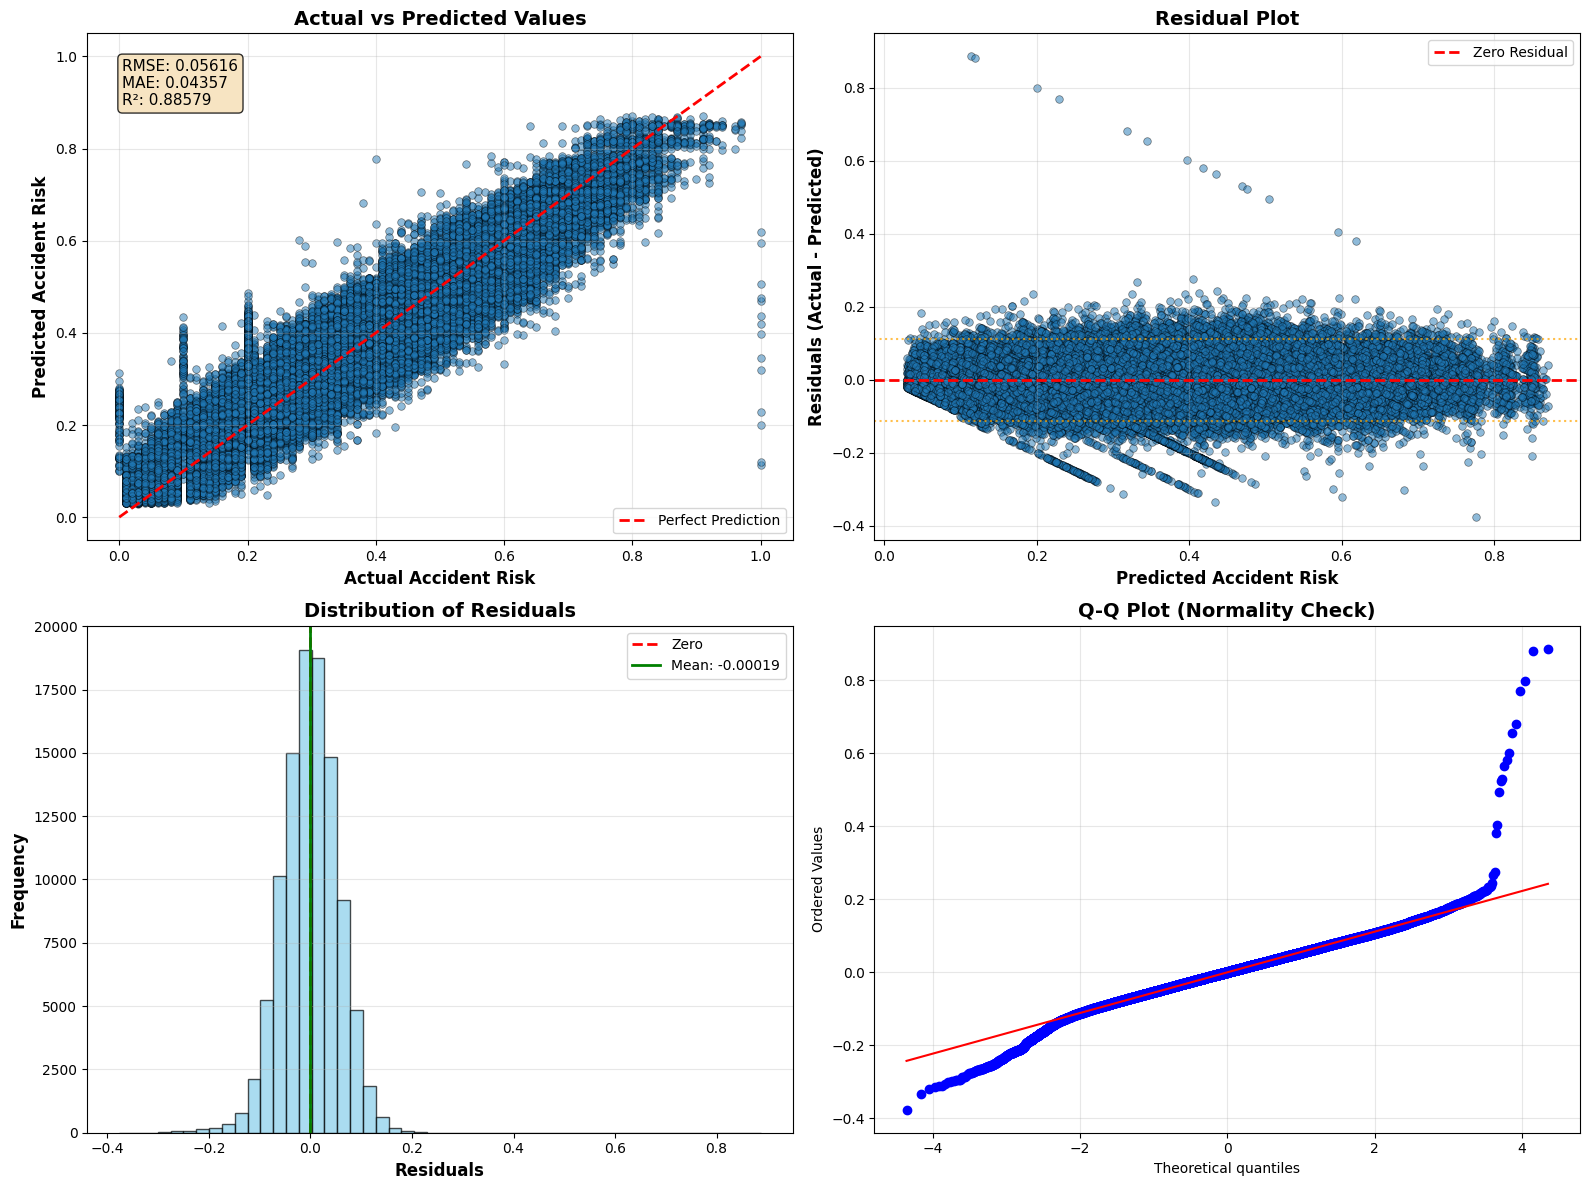

残差分析サマリー
サンプル数: 103551

【評価指標】
RMSE (Root Mean Squared Error): 0.056157
MAE  (Mean Absolute Error):     0.043568
R²   (Coefficient of Determination): 0.885791

【残差統計】
残差の平均:   -0.000185
残差の標準偏差: 0.056156
残差の最小値: -0.376663
残差の最大値: 0.886654

【外れ値検出】
±2σを超える外れ値の数: 4236 (4.09%)

2. 予測範囲別の残差分析


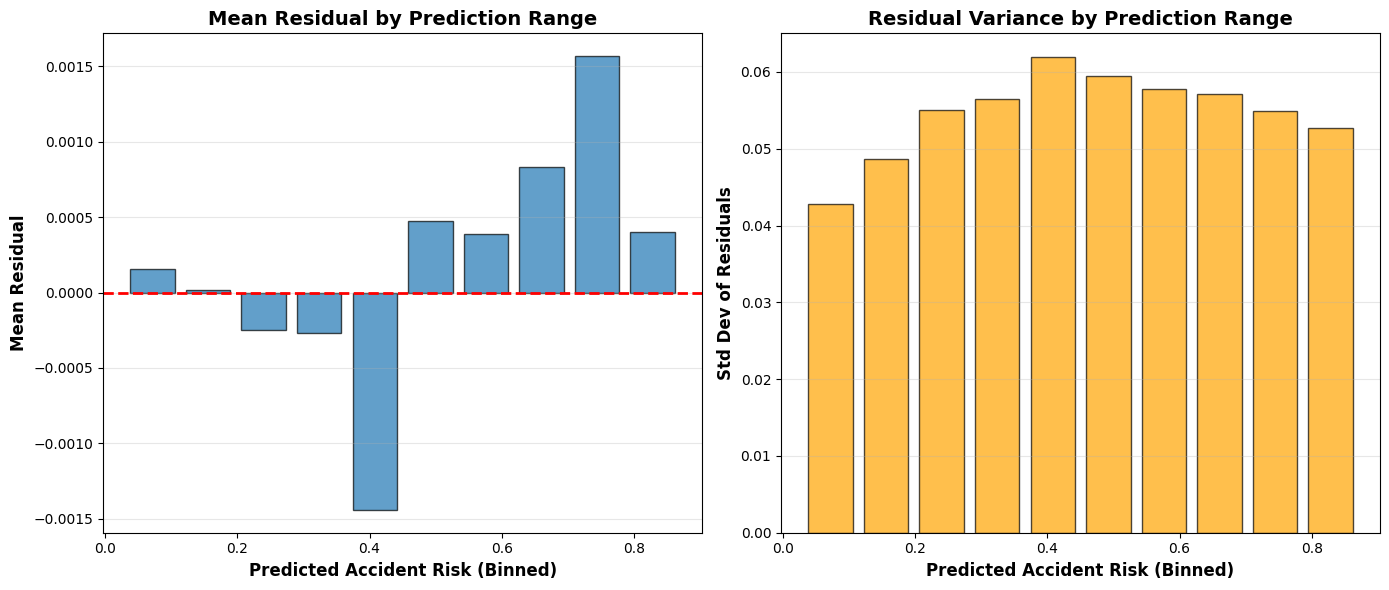


3. 誤差分布の詳細分析


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_29676/2515583609.py:192: RuntimeWarning: divide by zero encountered in divide
  error_percent = (residuals / y_test) * 100
/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_29676/2515583609.py:203: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)


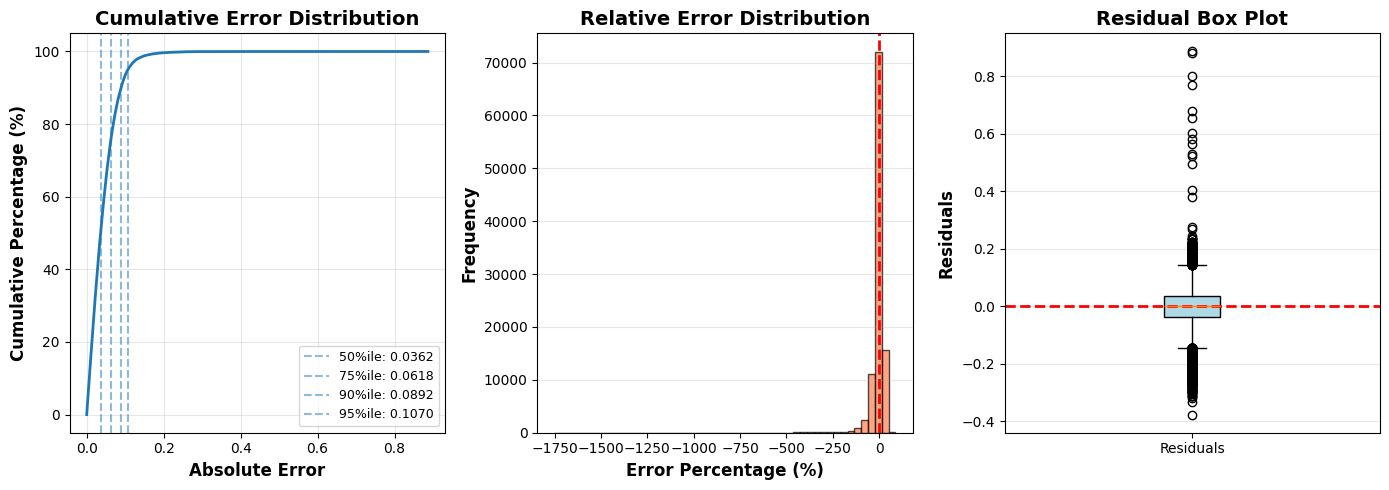


誤差パーセンタイル:
25%: 0.017057
50%: 0.036181
75%: 0.061846
90%: 0.089213
95%: 0.107009
99%: 0.156309


In [31]:
#"""
# 1. 総合分析（最も重要）
print("=" * 60)
print("1. 総合残差分析")
print("=" * 60)
residuals = plot_residual_analysis(y_test.values, final_pred.flatten())

# 2. 範囲別分析
print("\n" + "=" * 60)
print("2. 予測範囲別の残差分析")
print("=" * 60)
plot_residual_by_range(y_test.values, final_pred.flatten(), n_bins=10)

# 3. 誤差分布分析
print("\n" + "=" * 60)
print("3. 誤差分布の詳細分析")
print("=" * 60)
plot_error_distribution(y_test.values, final_pred.flatten())
#"""

In [34]:
# --- XGBoostの予測 ---
d_predict = xgb.DMatrix(predict_X)
xgb_pred_new = xgb_model.predict(d_predict)

lgb_pred_new = lgb_model.predict(predict_X)

# --- Deep Learningの予測 ---
deep_pred_new = deep_model.predict(predict_X).reshape(-1)

# --- 最適重み（Optunaの結果を使用）---
final_pred_new = best_w_xgb * xgb_pred_new + best_w_lgb * lgb_pred_new + best_w_dl * deep_pred_new

predict_df = pd.DataFrame(final_pred_new, columns=['accident_risk'])
submission = pd.concat([predict['id'], predict_df], axis=1)

display(submission.head())
print(submission.isnull().sum())


5394/5394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


,id,accident_risk
0,517754,0.297646
1,517755,0.122923
2,517756,0.182416
3,517757,0.315254
4,517758,0.407289


id               0
accident_risk    0
dtype: int64


In [35]:
file_path = '../submit/hybrid/hybrid_model_2.csv'

if os.path.exists(file_path):
     print(f"ファイルが既にあります{file_path}.")
else:
    submission.to_csv(file_path, index=False)
    print(f"ファイルを保存しました: {file_path}")

ファイルを保存しました: ../submit/hybrid/hybrid_model_2.csv
